<a href="https://colab.research.google.com/github/vilaparthibhaskar/IT7103/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

autocars = pd.read_csv('/content/drive/MyDrive/PDA/auto-mpg.csv')
autocars.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [117]:
autocars.shape

(398, 9)

In [119]:
autocars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


In [120]:
from sklearn.model_selection import train_test_split

traindata, testdata = train_test_split(autocars, test_size = 0.25) #testsize = 0.25 means that 25% of data will be for testing, 75% for training
traindata.shape, testdata.shape

((298, 9), (100, 9))

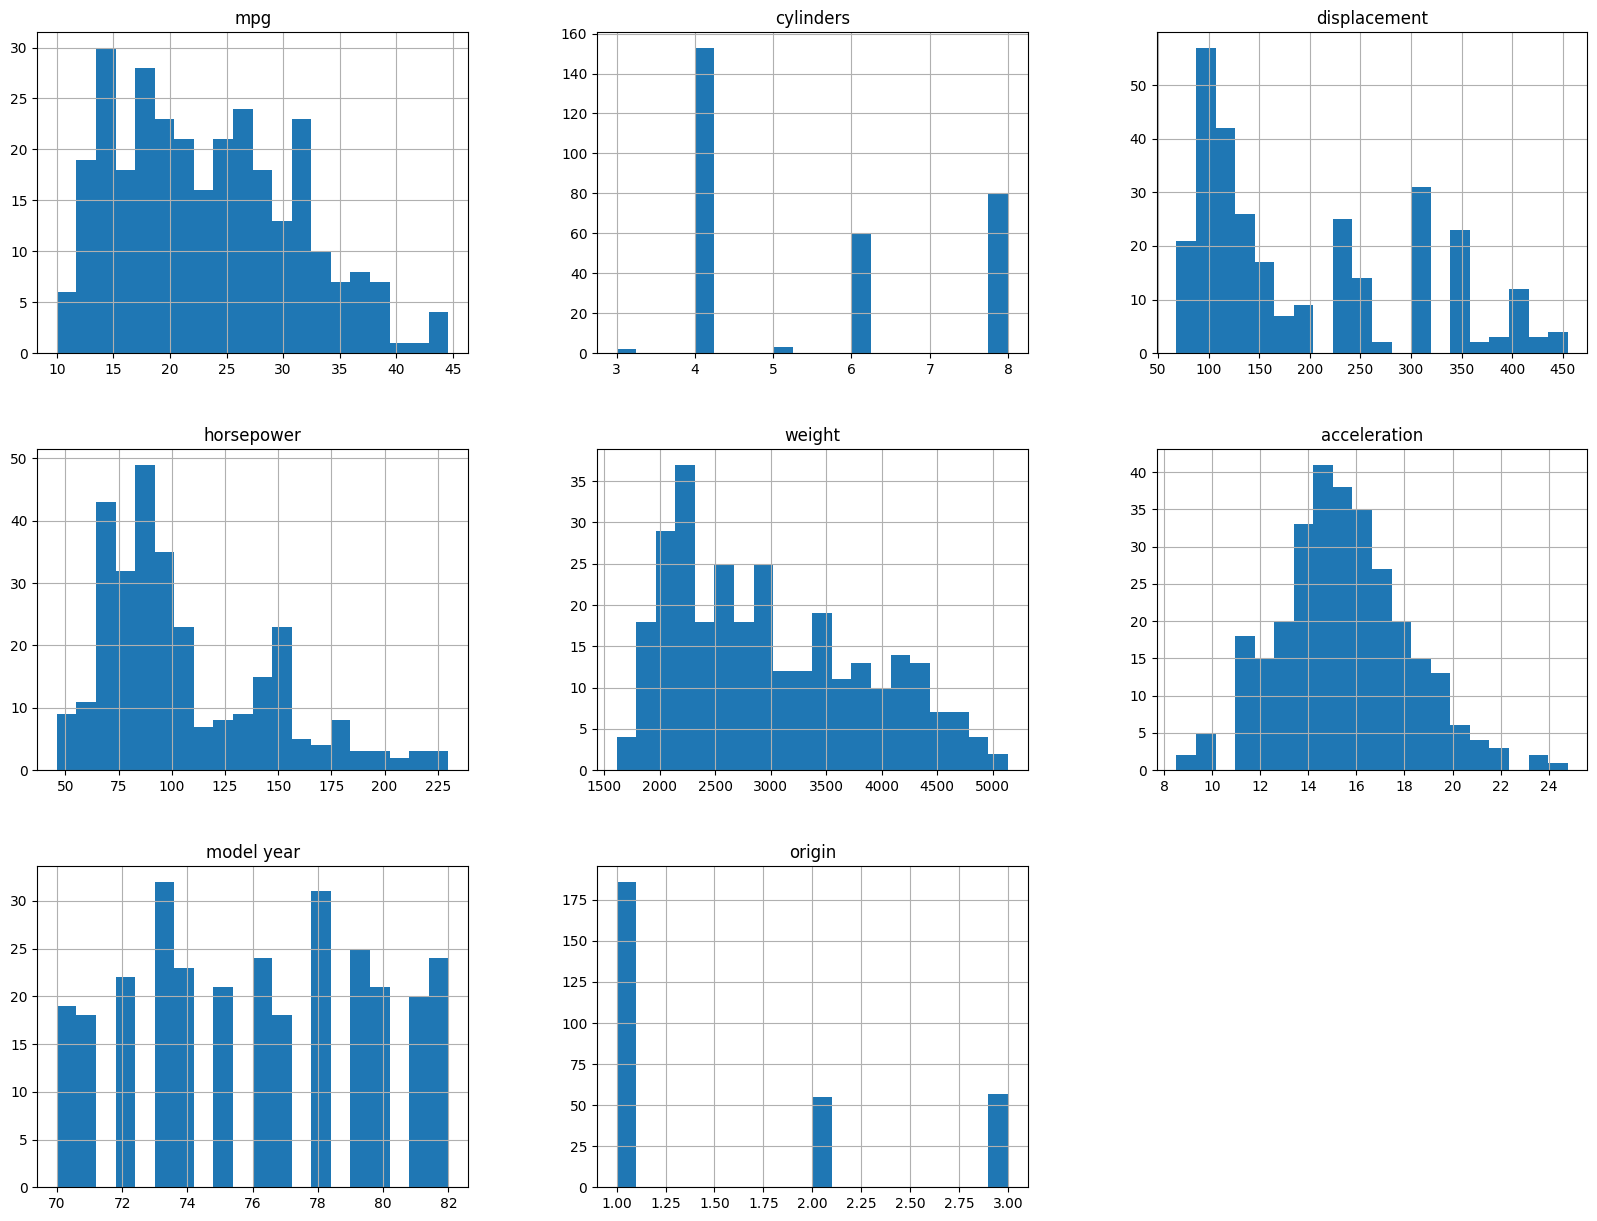

In [121]:
from matplotlib import pyplot as plt

traindata.hist(bins=20, figsize=(20,15))
plt.show()

In [122]:
num_sym, num_skew, cat_cols =[], [], []
target = 'displacement'
for col in autocars.columns:
  if col == target:
    continue
  if (autocars[col].dtypes == np.int64) or (autocars[col].dtypes == np.float64):
    if -0.5 <= autocars[col].skew() <= 0.5:
      num_sym.append(col)
    else:
      num_skew.append(col)
  else:
    cat_cols.append(col)
print(num_sym, num_skew, cat_cols)

['mpg', 'acceleration', 'model year'] ['cylinders', 'horsepower', 'weight', 'origin'] ['car name']


In [123]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

num_pipeline = Pipeline([                           #now we need a small pipeline for numeric columns since it has two steps
    ('impute', SimpleImputer(strategy='median')),   #this step will impute missing values using column medians
    ('standardize', StandardScaler())               #this step will scale all numeric columns
])

def log_transformation(x):
    return np.log(x+0.1)

log_pipeline = Pipeline([                                        #now we need a small pipeline for numeric columns since it has two steps
    ('impute', SimpleImputer(strategy='median')),                #this step will impute missing values using column medians
    ('log transform', FunctionTransformer(log_transformation)), #this include a log transformation into the pipeline
    ('standardize', StandardScaler())                            #this step will scale all numeric columns
])

processing_pipeline = ColumnTransformer([                                                      #this transformer merges the processed numeric columns and class columns
    ('numeric', num_pipeline, num_sym),                                                       #numeric columns
    ('log', log_pipeline, num_skew),                                                           #log columns
    ('class', OneHotEncoder(max_categories=6, handle_unknown='infrequent_if_exist'), cat_cols) #encoder to transform class columns to numeric, this will automatically handle missing data
  ])

In [124]:
processing_pipeline

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize',
                                                  StandardScaler())]),
                                 ['mpg', 'acceleration', 'model year']),
                                ('log',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('log transform',
                                                  FunctionTransformer(func=<function log_transformation at 0x7822254be560>)),
                                                 ('standardize',
                                                  StandardScaler())]),
                                 ['cylinders', 'horsepower', 'weight',
                                  'origin']),
                                ('class',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               max_categories=6),
                                 ['car name'])])

In [125]:
processing_pipeline.fit(traindata)  # training the pipeline on training data

train_processed = processing_pipeline.transform(traindata) #transformating the traindata
test_processed = processing_pipeline.transform(testdata)   #transformating the testdata

print(train_processed.shape)
print(test_processed.shape)

(298, 13)
(100, 13)
